# Spam Classifier

## Requirements
If you are running this in colab you will need to download the trec07p email database and also 4 text files which define the training and testing sets and their labels. The cells below will download the files from your google drive if they are in a folder called 'spamdata'.  The 4 text files are:

* train_set.txt
* train_label.txt
* test_set.txt
* test_label.txt

The database is called trec07p.tgz and can be downloaded from:

https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/trec07p.tgz

If you are running this locally the text files should be in the same folder as the python notebook and the trec07p folder should be in a folder called 'Emails'.

## Reference
Using sections of code from Sie Huai Gan, 2018, https://towardsdatascience.com/email-spam-detection-1-2-b0e06a5c0472, https://github.com/huai99/Email-Spam-Detection-Python/blob/master/Email%20Spamming%20(Medium%20Part%201).ipynb

and using multiple functions from the scikit-learn library, https://scikit-learn.org/stable/modules/classes.html

and adopting a feature selection method using the ExtraTreesClasssifier from https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
! cp /content/drive/My\ Drive/spamdata/trec07p.tgz ./ 
! tar xvf trec07p.tgz >/dev/null
! mkdir Emails
! mv trec07p Emails/
! cp /content/drive/My\ Drive/spamdata/*.txt ./

mkdir: cannot create directory ‘Emails’: File exists
mv: cannot move 'trec07p' to 'Emails/trec07p': Directory not empty


In [17]:
#import necessary packages
import os
import glob 
import numpy as np
import email
import shutil
import re
import string
from time import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score,accuracy_score,roc_curve,auc,roc_auc_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##Load Dataset

In [0]:

email_folder = os.path.join("Emails", "trec07p")

file = open(os.path.join(email_folder, "full", "index"))

ham_path = []
spam_path = []
bad_lines = []

for line in file:
    match = re.search('(.*) .*\.(\d*)', line)
    if match:
        file_number = match.group(2)
        if match.group(1) == "spam":
            spam_path.append(match.group(2))
        elif match.group(1) == "ham":
            ham_path.append(match.group(2))
        else:
            bad_lines.append(line)
file.close()

import random

random.shuffle(ham_path)
random.shuffle(spam_path)


In [0]:
#select number of emails to use
total_mails = 5000
# made 66% of emails spam to reflect corpus
spam_mails = round(total_mails*0.66)
ham_mails = total_mails-spam_mails

ham_path = ham_path[:ham_mails]
spam_path = spam_path[:spam_mails]

## Set parameters
Change below parameters to determine settings to run on 

In [0]:
#if True then use only the subject of the emails
use_subject = False
#if True then use pre-existing subset of emails
use_set = False
#if True then classify a particular test email, note - can only be done using the importance feature selection method
test_email = False
if test_email == True:
    location = "723"  #number of email in corpus to test
#if True then classify a chosen test string, note - can only be done using the importance feature selection method
test_string = False
if test_string == True:
    test_words = "You have won a large jackpot! Click this link to claim your prize:" #string to test
#choose vectorizer and n-gram model
n_gram = 1 # change to change the number of words per feature
tfidf = False #term freq - inverse document freq vectorizer
count = True #count vectorizer
#choose feature selection method and feature importance criteria
several_criteria = False #select as True if using several feature selection methods
mutual_info = False # some need a choice between using mutual information and chi squared as functions to select features
chisqr = True #only one of chisqr and mutual_info should be true
threshold = False #using variance threshold to delete some features
k_best = False #selecting the k best features
s_perc = False #selecting a percentile of the best features
pca = False #principal component analysis - decomposition for dimensionality reduction
importance = True #feature importance using ExtraTreesClassifier and selecting best percentile of features from model
#choose scaler/transformer
one_hot =  False # keep False, was tested but not able to work
standardize = False #standard scaler
max_abs = False #max-abs scaler
robust = False #robust to outliers
power = False #makes data more Gaussian-like
quantile_gauss = False #Gaussian output
quantile_uniform = False #uniform output
normal = False #normalizes data
#optional metrics
roc = True #plot roc curves
prec_curve = True #plot precision-recall curves
#choose filters to test
naive_bayes = True #naive bayes with Gaussian kernel
linear_svc = True #Support vector machine with linear kernel
mnb = True #Multinomial Naive Bayes
svc = True #Support vector machine with rbf kernel
mlp = True #Multi-layer perceptron - neural networks
knn = True #K nearest neighbours
dtc = True #Decision tree classifier
ada = True #AdaBoost ensemble classifier
three_filters = True #combining 3 chosen filters
if three_filters == True: #change letters to change filters used - must be True above
    filter1 = "NB" #NB = gaussian naive bayes, LSVM = linear support vector machine, MNB = multinomial naive bayes
    filter2 = "LSVM" #SVM = support vector machine (rbf), MLP = multi-layer perceptron, KNN = k nearest neighbours
    filter3 = "MLP" #DTC = decision tree classifier, ADA = adaboost
    first_predict=[]
    second_predict=[]
    third_predict=[]
else:
    filter1 = ""
    filter2 = ""
    filter3 = ""

## Create/Use Saved Dataset
If creating a new dataset, split into training and testing sets and save


In [21]:

from sklearn.model_selection import train_test_split

t0 = time()

if use_set == False:
    #generate new training and test sets
    #splitting into ham and spam train and test samples
    ham_sample = np.array([train_test_split(ham_path)])
    ham_train = np.array([])
    ham_test = np.array([])
    for o in ham_sample:
        ham_train = np.concatenate((ham_train,o[0]),axis=0)
        ham_test = np.concatenate((ham_test,o[1]),axis=0)

    print("ham training,testing:")
    print(ham_train.shape, ham_test.shape)

    spam_sample = np.array([train_test_split(spam_path)])
    spam_train = np.array([])
    spam_test = np.array([])
    for o in spam_sample:
        spam_train = np.concatenate((spam_train,o[0]),axis=0)
        spam_test = np.concatenate((spam_test,o[1]),axis=0)

    print("spam training,testing:")
    print(spam_train.shape, spam_test.shape)

    ham_train_label = [0]*ham_train.shape[0] # 0 for every ham email
    spam_train_label = [1]*spam_train.shape[0] # 1 for every spam email
    x_train = np.concatenate((ham_train,spam_train)) # join into one training set
    y_train = np.concatenate((ham_train_label,spam_train_label)) # join labels for training set

    ham_test_label = [0]*ham_test.shape[0]
    spam_test_label = [1]*spam_test.shape[0]
    x_test = np.concatenate((ham_test,spam_test))
    y_test = np.concatenate((ham_test_label,spam_test_label))

    # randomly shuffling emails and labels in both sets
    train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))
    test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))

    x_train = x_train[train_shuffle_index]
    y_train = y_train[train_shuffle_index]

    x_test = x_test[test_shuffle_index]
    y_test = y_test[test_shuffle_index]

    # save in files for future use of set
    f_train = open("train_set.txt","w")
    f_train_label = open("train_label.txt","w")
    f_test = open("test_set.txt","w")
    f_test_label = open("test_label.txt","w")
    for i in range(len(x_train)):
        f_train.write(x_train[i]+"\n")
        f_train_label.write(str(y_train[i])+"\n")
    for i in range(len(x_test)):
        f_test.write(x_test[i]+"\n")
        f_test_label.write(str(y_test[i])+"\n")
    f_train.close()
    f_train_label.close()
    f_test.close()
    f_test_label.close()
else: #use existing train and test sets
    f_train = open("train_set.txt","r")
    f_train_label = open("train_label.txt","r")
    f_test = open("test_set.txt","r")
    f_test_label = open("test_label.txt","r")
    
    x_train = np.loadtxt(f_train,dtype=str,delimiter='\n')
    y_train = np.loadtxt(f_train_label,dtype=int,delimiter='\n')
    x_test = np.loadtxt(f_test,dtype=str,delimiter='\n')
    y_test = np.loadtxt(f_test_label,dtype=int,delimiter='\n')
    
    f_train.close()
    f_train_label.close()
    f_test.close()
    f_test_label.close()


ham training,testing:
(1275,) (425,)
spam training,testing:
(2475,) (825,)


##Get Email Contents

In [0]:

#get the plain text or html contents of the emails
def get_email_content(email_path):
    mail_file = os.path.join(email_folder, "data", "inmail."+str(email_path))
    file = open(mail_file,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        if use_subject:
            return msg['subject']
        else:
            for part in msg.walk():
                if part.get_content_type() == 'text/plain' or part.get_content_type() == 'text/html':
                    subject = str(msg['subject'])
                    return subject+part.get_payload()
    except Exception as e:
        print(e)

def get_email_content_bulk(email_paths):
    email_contents = [get_email_content(o) for o in email_paths]
    return email_contents

#get contents of emails
x_train = get_email_content_bulk(x_train)
x_test = get_email_content_bulk(x_test)

##Pre-processing

Strip emails of unnecessary data and format for feature extraction

In [23]:
def remove_null(datas,labels):
    not_null_idx = [i for i,o in enumerate(datas) if o is not None]
    return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]

def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')

def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                        replace_newline,
                        to_lower,
                        remove_number,
                        remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

def word_stemmer(words):
    return [stemmer.stem(o) for o in words]

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(o) for o in words]

def clean_token_pipeline(words):
    #change word_lemmatizer to word_stemmer if want to change
    cleaning_utils = [remove_stop_words,word_lemmatizer]
    for o in cleaning_utils:
        words = o(words)
    return words

def convert_to_feature(raw_tokenize_data):
    raw_sentences = [' '.join(o) for o in raw_tokenize_data]
    return vectorizer.transform(raw_sentences)

#remove emails with no contents
x_train,y_train = remove_null(x_train,y_train)
x_test,y_test = remove_null(x_test,y_test)

#cleans email data
x_train = [clean_up_pipeline(o) for o in x_train]
x_test = [clean_up_pipeline(o) for o in x_test]

lemmatizer = WordNetLemmatizer()

#convert into tokens
x_train = [word_tokenize(o) for o in x_train]
x_test = [word_tokenize(o) for o in x_test]

#getting meaning of words
x_train = [clean_token_pipeline(o) for o in x_train]
x_test = [clean_token_pipeline(o) for o in x_test]

if test_email == True:
    content = True
    test = get_email_content_bulk([location])
    print(test)
    if test[0] == None:
        content= False
    else:
        test = [clean_up_pipeline(o) for o in test]
        test = [word_tokenize(o) for o in test]
        test = [clean_token_pipeline(o) for o in test]

if test_string == True:
    string_content = True
    if test_words == "":
        string_content = False
    else:
        test_words = [clean_up_pipeline(o) for o in test_words]
        test_words = [word_tokenize(o) for o in test_words]
        test_words = [clean_token_pipeline(o) for o in test_words]


['All products for your health!']


##Feature Extraction

In [0]:
if tfidf == True:
    #converts to feature vectors using tf-idf
    vectorizer = TfidfVectorizer(analyzer = 'word',ngram_range = (n_gram,n_gram))
elif count ==  True:
    #count occurrences of features
    vectorizer = CountVectorizer(analyzer = 'word',ngram_range = (n_gram,n_gram))

raw_sentences = [' '.join(o) for o in x_train]
vectorizer.fit(raw_sentences)
x_train_features = convert_to_feature(x_train)
x_test_features = convert_to_feature(x_test)


if test_email==True and content == True:
    test_features = convert_to_feature(test)

if test_string == True and string_content == True:
    test_string_features = convert_to_feature(test_words)

from sklearn.feature_selection import chi2,mutual_info_classif


##Feature Selection

In [0]:
if threshold == True:
    from sklearn.feature_selection import VarianceThreshold
    selector = VarianceThreshold(threshold=0.0001)
    selector.fit(x_train_features)
    x_train_selection = selector.transform(x_train_features)
    x_test_selection = selector.transform(x_test_features)
    if several_criteria == True:
        x_train_features = x_train_selection
        x_test_features = x_test_selection

if k_best == True:
    from sklearn.feature_selection import SelectKBest
    if mutual_info == True:
        selector = SelectKBest(mutual_info_classif,k=100)
    if chisqr == True:
        selector = SelectKBest(chi2,k=100)
    selector.fit(x_train_features,y_train)
    x_train_selection = selector.transform(x_train_features)
    x_test_selection = selector.transform(x_test_features)
    if several_criteria == True:
        x_train_features = x_train_selection
        x_test_features = x_test_selection

if s_perc == True:
    from sklearn.feature_selection import SelectPercentile
    if mutual_info == True:
        selector = SelectPercentile(mutual_info_classif)
    if chisqr == True:
        selector = SelectPercentile(chi2)
    selector.fit(x_train_features,y_train)
    x_train_selection = selector.transform(x_train_features)
    x_test_selection = selector.transform(x_test_features)
    if several_criteria == True:
        x_train_features = x_train_selection
        x_test_features = x_test_selection

if pca == True:
    from sklearn.decomposition import PCA
    decomp = PCA()
    decomp.fit(x_train_features.toarray())
    x_train_selection = decomp.transform(x_train_features.toarray())
    x_test_selection = decomp.transform(x_test_features.toarray())
    if several_criteria == True:
        x_train_features = x_train_selection
        x_test_features = x_test_selection

if importance == True:
    #get the importances of the features
    model = ExtraTreesClassifier(n_estimators=100)
    model.fit(x_train_features, y_train)
    features = model.feature_importances_
    #features_normal= np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0) #normalised features

    #use the importances to select the best features
    percentile = np.percentile(features,90) #change percentile to change number of features selected
    selection = SelectFromModel(model, threshold =percentile, prefit = True)
    x_train_selection = selection.transform(x_train_features)
    x_test_selection = selection.transform(x_test_features)
    if test_email == True:
        test_selection = selection.transform(test_features)
    if test_string == True:
        test_string_selection = selection.transform(test_string_features)



##Standardization Methods

In [26]:

if one_hot == True:
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(handle_unknown='ignore')
    try:
        x_train_selection = enc.fit_transform(x_train_selection.toarray())
        x_test_selection = enc.fit_transform(x_test_selection.toarray())
    except AttributeError:
        x_train_selection = enc.fit_transform(x_train_selection)
        x_test_selection = enc.fit_transform(x_test_selection)
if standardize == True:
    from sklearn.preprocessing import StandardScaler
    x_train_selection = StandardScaler(with_mean = False).fit_transform(x_train_selection)
    x_test_selection = StandardScaler(with_mean=False).fit_transform(x_test_selection)
if max_abs == True:
    from sklearn.preprocessing import MaxAbsScaler
    x_train_selection = MaxAbsScaler().fit_transform(x_train_selection)
    x_test_selection = MaxAbsScaler().fit_transform(x_test_selection)
if robust == True:
    from sklearn.preprocessing import RobustScaler
    x_train_selection = RobustScaler(with_centering = False).fit_transform(x_train_selection)
    x_test_selection = RobustScaler(with_centering = False).fit_transform(x_test_selection)
if power == True:
    from sklearn.preprocessing import PowerTransformer
    x_train_selection = PowerTransformer().fit_transform(x_train_selection.toarray())
    x_test_selection = PowerTransformer().fit_transform(x_test_selection.toarray())
if quantile_gauss == True:
    from sklearn.preprocessing import QuantileTransformer
    x_train_selection = QuantileTransformer(output_distribution = "normal").fit_transform(x_train_selection)
    x_test_selection = QuantileTransformer(output_distribution = "normal").fit_transform(x_test_selection)
if quantile_uniform == True:
    from sklearn.preprocessing import QuantileTransformer
    x_train_selection = QuantileTransformer(output_distribution = "uniform").fit_transform(x_train_selection)
    x_test_selection = QuantileTransformer(output_distribution = "uniform").fit_transform(x_test_selection)
if normal == True:
    from sklearn.preprocessing import Normalizer
    x_train_selection = Normalizer().fit_transform(x_train_selection)
    x_test_selection = Normalizer().fit_transform(x_test_selection)
    
t1 = time()-t0
print("pre-processing time: %0.2fs" % t1)


pre-processing time: 41.49s


##Train Classifier
Train the selected classifer and return the results

In [0]:
def analysis(classifier):
    global first_predict
    global second_predict
    global third_predict
    global x1,x2,x3,s1,s2,s3
    t0 = time()
    try:
        clf.fit(x_train_selection.toarray(),y_train)
    except AttributeError:
        clf.fit(x_train_selection,y_train)
    t2 = time() -t0
    print("training time: %0.2fs" % t2)

    t0=time()
    try:
        y_predict = clf.predict(x_test_selection.toarray())
    except AttributeError:
        y_predict = clf.predict(x_test_selection)
    t3 = time()-t0
    print("testing time: %0.2fs" % t3)
    print("\nConfusion Matrix")
    print(confusion_matrix(y_test,y_predict))


    if filter1 == classifier:
        first_predict = y_predict
    if filter2 == classifier:
        second_predict = y_predict
    if filter3 == classifier:
        third_predict = y_predict
        
    tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()

    print(" ")
    print("True Negative: ",tn)
    print("False Positive: ",fp)
    print("False Negative: ",fn)
    print("True Positive: ",tp)
    print(" ")
    print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test,y_predict)))
    from sklearn.metrics import balanced_accuracy_score,average_precision_score,precision_recall_curve,classification_report,zero_one_loss
    print("Balanced Accuracy: {:.2f}%".format(100 * balanced_accuracy_score(y_test,y_predict)))#average of recall obtained on each class - for imbalanced datasets
    print("Average Precision: {:.2f}%".format(100 * average_precision_score(y_test,y_predict)))
    print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_predict)))
    print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
    print("Zero-one loss: {:.2f}%".format(100 * zero_one_loss(y_test, y_predict))) # % misclassifications
    print("\nReport: ",classification_report(y_test,y_predict))

    if roc == True:
        #roc curve
        auc1= roc_auc_score(y_test, y_predict)
        print('AUC: %.2f' % auc1)
        fpr, tpr, threshold = roc_curve(y_test, y_predict,pos_label=1)
        roc_auc = auc(fpr, tpr)
        import matplotlib.pyplot as plt
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, color = 'blue', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    if prec_curve == True:
        import matplotlib.pyplot as plt
        prec, rec, thresh = precision_recall_curve(y_test,y_predict)
        prec_auc = auc(rec, prec)
        plt.title('Precision Recall Curve')
        plt.plot(rec, prec, color = 'blue',label = 'AUC = %0.2f' % prec_auc)
        plt.legend(loc = 'lower right')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.show()

    
    if test_email ==True:
        if content == False:
            print("Email contained no content")
        else:
            y_predict = clf.predict(test_selection.toarray())
            print("Test Email: ")
            if y_predict[0] == 1:
                print("spam")
                if three_filters == True:
                    if filter1 == classifier:
                        x1 = "spam"
                    elif filter2 == classifier:
                        x2 = "spam"
                    elif filter3 == classifier:
                        x3 = "spam"
            else:
                print("ham")
                if three_filters == True:
                    if filter1 == classifier:
                        x1 = "ham"
                    elif filter2 == classifier:
                        x2 = "ham"
                    elif filter3 == classifier:
                        x3 = "ham"
            try:
                predict_prob = clf.predict_proba(test_selection.toarray())
                print("Class Probabilities - ham: {:.2f}%".format(100 * predict_prob[0][0]))
                print("- spam: {:.2f}%".format(100 * predict_prob[0][1]))
            except AttributeError:
                print("Could not get class probabilities")

    if test_string ==True:
        if string_content == False:
            print("String contained no content")
        else:
            y_predict = clf.predict(test_string_selection.toarray())
            print("Test String: ")
            if y_predict[0] == 1:
                print("spam")
                if three_filters == True:
                    if filter1 == classifier:
                        s1 = "spam"
                    elif filter2 == classifier:
                        s2 = "spam"
                    elif filter3 == classifier:
                        s3 = "spam"
            else:
                print("ham")
                if three_filters == True:
                    if filter1 == classifier:
                        s1 = "ham"
                    elif filter2 == classifier:
                        s2 = "ham"
                    elif filter3 == classifier:
                        s3 = "ham"
            try:
                predict_prob = clf.predict_proba(test_string_selection.toarray())
                print("Class Probabilities - ham: {:.2f}%".format(100 * predict_prob[0][0]))
                print("- spam: {:.2f}%".format(100 * predict_prob[0][1]))
            except AttributeError:
                print("Could not get class probabilities")


##Classifiers


######################################
Naive Bayes - Gaussian
######################################

training time: 0.70s
testing time: 0.16s

Confusion Matrix
[[417   8]
 [ 49 776]]
 
True Negative:  417
False Positive:  8
False Negative:  49
True Positive:  776
 
Accuracy: 95.44%
Balanced Accuracy: 96.09%
Average Precision: 97.02%
F1 Score: 96.46%
Precision: 98.98%
Recall: 94.06%
Zero-one loss: 4.56%

Report:                precision    recall  f1-score   support

           0       0.89      0.98      0.94       425
           1       0.99      0.94      0.96       825

    accuracy                           0.95      1250
   macro avg       0.94      0.96      0.95      1250
weighted avg       0.96      0.95      0.95      1250

AUC: 0.96


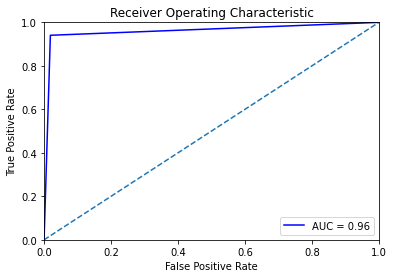

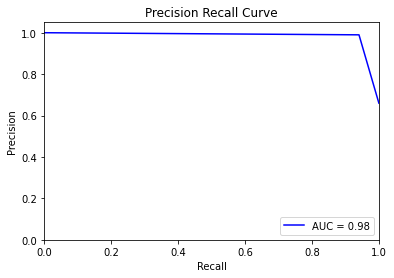

Test Email: 
spam
Class Probabilities - ham: 0.00%
- spam: 100.00%
Test String: 
spam
Class Probabilities - ham: 0.00%
- spam: 100.00%

######################################
Naive Bayes - Multinomial
######################################

training time: 0.50s
testing time: 0.05s

Confusion Matrix
[[414  11]
 [ 39 786]]
 
True Negative:  414
False Positive:  11
False Negative:  39
True Positive:  786
 
Accuracy: 96.00%
Balanced Accuracy: 96.34%
Average Precision: 97.08%
F1 Score: 96.92%
Precision: 98.62%
Recall: 95.27%
Zero-one loss: 4.00%

Report:                precision    recall  f1-score   support

           0       0.91      0.97      0.94       425
           1       0.99      0.95      0.97       825

    accuracy                           0.96      1250
   macro avg       0.95      0.96      0.96      1250
weighted avg       0.96      0.96      0.96      1250

AUC: 0.96


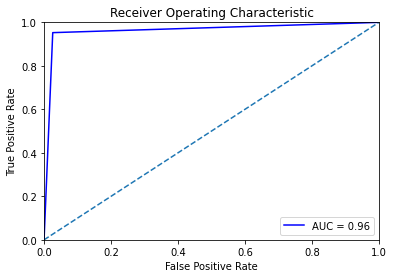

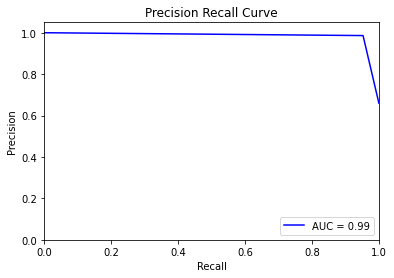

Test Email: 
spam
Class Probabilities - ham: 4.25%
- spam: 95.75%
Test String: 
spam
Class Probabilities - ham: 34.01%
- spam: 65.99%

######################################
SVM (linear kernel)
######################################

training time: 0.99s
testing time: 0.05s

Confusion Matrix
[[411  14]
 [  9 816]]
 
True Negative:  411
False Positive:  14
False Negative:  9
True Positive:  816
 
Accuracy: 98.16%
Balanced Accuracy: 97.81%
Average Precision: 97.96%
F1 Score: 98.61%
Precision: 98.31%
Recall: 98.91%
Zero-one loss: 1.84%

Report:                precision    recall  f1-score   support

           0       0.98      0.97      0.97       425
           1       0.98      0.99      0.99       825

    accuracy                           0.98      1250
   macro avg       0.98      0.98      0.98      1250
weighted avg       0.98      0.98      0.98      1250

AUC: 0.98


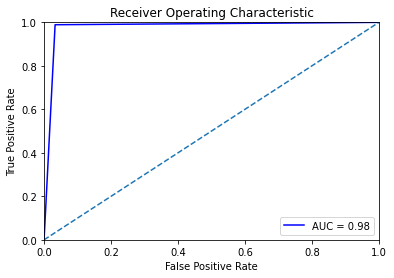

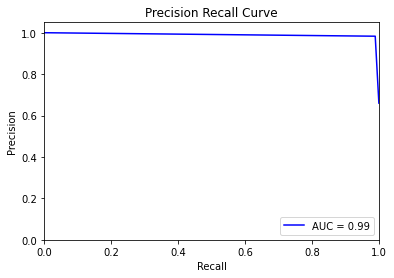

Test Email: 
spam
Could not get class probabilities
Test String: 
spam
Could not get class probabilities

######################################
SVM (rbf kernel)
######################################

training time: 135.30s
testing time: 41.85s

Confusion Matrix
[[199 226]
 [  2 823]]
 
True Negative:  199
False Positive:  226
False Negative:  2
True Positive:  823
 
Accuracy: 81.76%
Balanced Accuracy: 73.29%
Average Precision: 78.43%
F1 Score: 87.83%
Precision: 78.46%
Recall: 99.76%
Zero-one loss: 18.24%

Report:                precision    recall  f1-score   support

           0       0.99      0.47      0.64       425
           1       0.78      1.00      0.88       825

    accuracy                           0.82      1250
   macro avg       0.89      0.73      0.76      1250
weighted avg       0.85      0.82      0.80      1250

AUC: 0.73


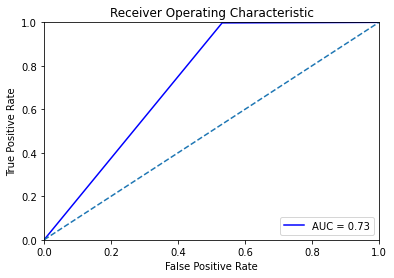

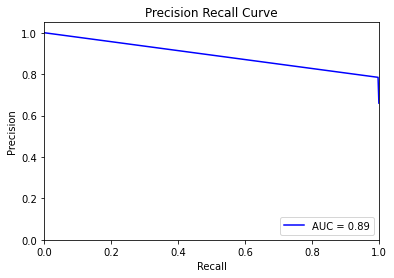

Test Email: 
spam
Could not get class probabilities
Test String: 
spam
Could not get class probabilities

######################################
MLP
######################################

Iteration 1, loss = 0.71099790
Validation score: 0.962667
Iteration 2, loss = 0.30189029
Validation score: 0.968000
Iteration 3, loss = 0.20901736
Validation score: 0.968000
Iteration 4, loss = 0.16685964
Validation score: 0.968000
Iteration 5, loss = 0.14174152
Validation score: 0.970667
Iteration 6, loss = 0.12600370
Validation score: 0.976000
Iteration 7, loss = 0.11320395
Validation score: 0.973333
Iteration 8, loss = 0.10426720
Validation score: 0.973333
Iteration 9, loss = 0.09784144
Validation score: 0.973333
Iteration 10, loss = 0.09068627
Validation score: 0.968000
Iteration 11, loss = 0.08681582
Validation score: 0.970667
Iteration 12, loss = 0.08301710
Validation score: 0.970667
Iteration 13, loss = 0.08009967
Validation score: 0.965333
Iteration 14, loss = 0.07660281
Validation score: 0.9

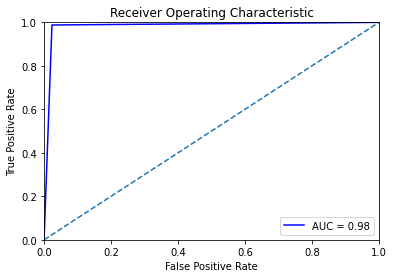

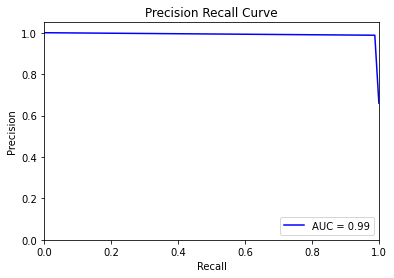

Test Email: 
spam
Class Probabilities - ham: 21.99%
- spam: 78.01%
Test String: 
spam
Class Probabilities - ham: 30.50%
- spam: 69.50%

######################################
KNN
######################################

training time: 4.69s
testing time: 58.92s

Confusion Matrix
[[317 108]
 [  2 823]]
 
True Negative:  317
False Positive:  108
False Negative:  2
True Positive:  823
 
Accuracy: 91.20%
Balanced Accuracy: 87.17%
Average Precision: 88.35%
F1 Score: 93.74%
Precision: 88.40%
Recall: 99.76%
Zero-one loss: 8.80%

Report:                precision    recall  f1-score   support

           0       0.99      0.75      0.85       425
           1       0.88      1.00      0.94       825

    accuracy                           0.91      1250
   macro avg       0.94      0.87      0.89      1250
weighted avg       0.92      0.91      0.91      1250

AUC: 0.87


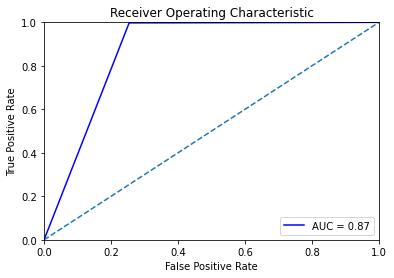

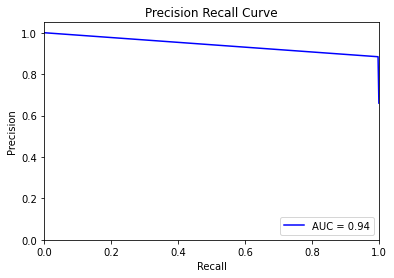

Test Email: 
spam
Class Probabilities - ham: 0.00%
- spam: 100.00%
Test String: 
spam
Class Probabilities - ham: 0.00%
- spam: 100.00%

######################################
Decision Tree
######################################

training time: 6.27s
testing time: 0.05s

Confusion Matrix
[[397  28]
 [ 17 808]]
 
True Negative:  397
False Positive:  28
False Negative:  17
True Positive:  808
 
Accuracy: 96.40%
Balanced Accuracy: 95.68%
Average Precision: 96.02%
F1 Score: 97.29%
Precision: 96.65%
Recall: 97.94%
Zero-one loss: 3.60%

Report:                precision    recall  f1-score   support

           0       0.96      0.93      0.95       425
           1       0.97      0.98      0.97       825

    accuracy                           0.96      1250
   macro avg       0.96      0.96      0.96      1250
weighted avg       0.96      0.96      0.96      1250

AUC: 0.96


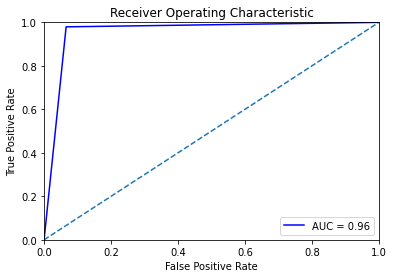

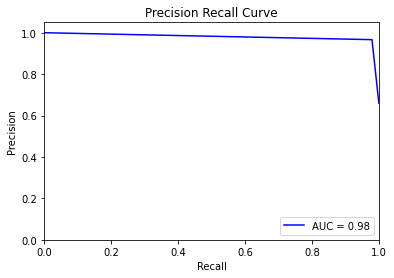

Test Email: 
spam
Class Probabilities - ham: 0.00%
- spam: 100.00%
Test String: 
spam
Class Probabilities - ham: 0.00%
- spam: 100.00%

######################################
AdaBoost
######################################

training time: 33.63s
testing time: 1.44s

Confusion Matrix
[[393  32]
 [ 13 812]]
 
True Negative:  393
False Positive:  32
False Negative:  13
True Positive:  812
 
Accuracy: 96.40%
Balanced Accuracy: 95.45%
Average Precision: 95.73%
F1 Score: 97.30%
Precision: 96.21%
Recall: 98.42%
Zero-one loss: 3.60%

Report:                precision    recall  f1-score   support

           0       0.97      0.92      0.95       425
           1       0.96      0.98      0.97       825

    accuracy                           0.96      1250
   macro avg       0.97      0.95      0.96      1250
weighted avg       0.96      0.96      0.96      1250

AUC: 0.95


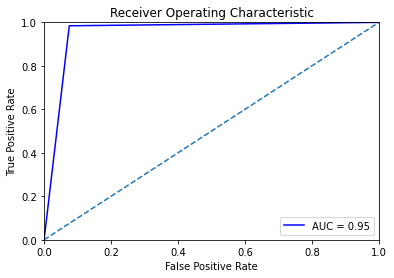

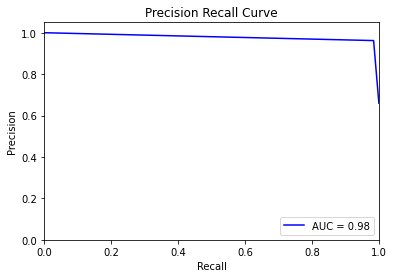

Test Email: 
spam
Class Probabilities - ham: 46.65%
- spam: 53.35%
Test String: 
spam
Class Probabilities - ham: 47.55%
- spam: 52.45%

######################################
Hybrid Filter
######################################

testing time: 0.00s
 
[[416   9]
 [  9 816]]
 
True Negative:  416
False Positive:  9
False Negative:  9
True Positive:  816
 
Accuracy: 98.56%
Balanced Accuracy: 98.40%
Average Precision: 98.55%
F1 Score: 98.91%
Precision: 98.91%
Recall: 98.91%
Zero-one loss: 1.44%

Report:                precision    recall  f1-score   support

           0       0.98      0.98      0.98       425
           1       0.99      0.99      0.99       825

    accuracy                           0.99      1250
   macro avg       0.98      0.98      0.98      1250
weighted avg       0.99      0.99      0.99      1250

AUC: 0.98


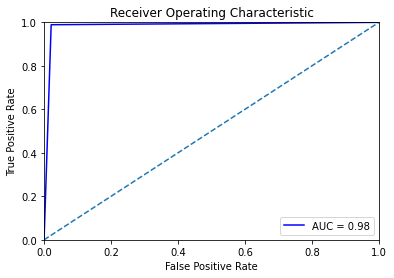

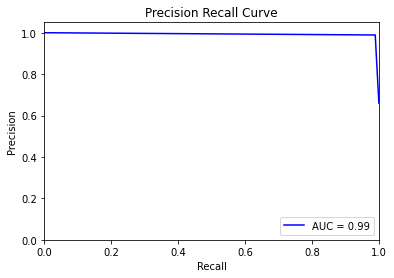

Test Email: 
spam
Test String: 
spam


In [28]:
##############################################################
#Naive Bayesian - Gaussian

if naive_bayes == True:
    print("\n######################################\nNaive Bayes - Gaussian\n######################################\n")
    clf = GaussianNB()
    analysis("NB")

##############################################################
#Naive Bayesian - Multinomial

if mnb == True:
    print("\n######################################\nNaive Bayes - Multinomial\n######################################\n")
    clf = MultinomialNB()
    analysis("MNB")
    
##############################################################
#Support Vector Machine with Linear kernel

if linear_svc == True:
    print("\n######################################\nSVM (linear kernel)\n######################################\n")
    clf = LinearSVC(max_iter=10000)
    analysis("LSVM")
    
###############################################################
#SVM without Linear kernel

if svc == True:
    print("\n######################################\nSVM (rbf kernel)\n######################################\n")
    clf = SVC(gamma = "scale",kernel="rbf")
    analysis("SVM")

##############################################################
#Neural Network - Multi-Layer Perceptron

if mlp == True:
    print("\n######################################\nMLP\n######################################\n")
    clf = MLPClassifier(alpha=1, max_iter=1000,activation="relu",solver = "adam",early_stopping=True,verbose=True,tol=0.00001)
    analysis("MLP")

#############################################################
#k Nearest Neighbours

if knn == True:
    print("\n######################################\nKNN\n######################################\n")
    clf = KNeighborsClassifier(n_neighbors=1,weights='distance')
    analysis("KNN")

#############################################################
#Decision Tree

if dtc == True:
    print("\n######################################\nDecision Tree\n######################################\n")
    clf = DecisionTreeClassifier(max_depth=None,criterion="entropy",class_weight = "balanced")#uses information gain
    analysis("DTC")

#############################################################
#AdaBoost

if ada == True:
    print("\n######################################\nAdaBoost\n######################################\n")
    clf = AdaBoostClassifier()
    analysis("ADA")
    
#############################################################################
# hybrid filter

if three_filters == True:
    print("\n######################################\nHybrid Filter\n######################################\n")
    t0=time()
    y_predict = []
    for i in range(len(first_predict)):
        if first_predict[i] == second_predict[i]:
            y_predict.append(first_predict[i])
        else:
            y_predict.append(third_predict[i])

    t3 = time()-t0
    print("testing time: %0.2fs" % t3)
    print(" ")
    print(confusion_matrix(y_test,y_predict))

    tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()

    print(" ")
    print("True Negative: ",tn)
    print("False Positive: ",fp)
    print("False Negative: ",fn)
    print("True Positive: ",tp)
    print(" ")
    print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test,y_predict)))
    from sklearn.metrics import balanced_accuracy_score,average_precision_score,precision_recall_curve,classification_report,zero_one_loss
    print("Balanced Accuracy: {:.2f}%".format(100 * balanced_accuracy_score(y_test,y_predict)))#average of recall obtained on each class - for imbalanced datasets
    print("Average Precision: {:.2f}%".format(100 * average_precision_score(y_test,y_predict)))#summarizes precision-recall curve - averages precisions for each threshold
    print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_predict)))
    print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
    print("Zero-one loss: {:.2f}%".format(100 * zero_one_loss(y_test, y_predict))) #misclassifications
    print("\nReport: ",classification_report(y_test,y_predict))

    if roc == True:
        #roc curve
        auc1= roc_auc_score(y_test, y_predict)
        print('AUC: %.2f' % auc1)
        fpr, tpr, threshold = roc_curve(y_test, y_predict,pos_label=1)
        roc_auc = auc(fpr, tpr)
        import matplotlib.pyplot as plt
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, color = 'blue', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    if prec_curve == True:
        import matplotlib.pyplot as plt
        prec, rec, thresh = precision_recall_curve(y_test,y_predict)
        prec_auc = auc(rec, prec)
        plt.title('Precision Recall Curve')
        plt.plot(rec, prec, color = 'blue',label = 'AUC = %0.2f' % prec_auc)
        plt.legend(loc = 'lower right')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.show()

    if test_email ==True:
        if content == False:
            print("Email contained no content")
        else:
            print("Test Email: ")
            if x1 == x2:
                print(x1)
            else:
                print(x3)

    if test_string ==True:
        if string_content == False:
            print("String contained no content")
        else:
            print("Test String: ")
            if s1 == s2:
                print(s1)
            else:
                print(s3)


